In [1]:
import librosa as lb
import librosa.display
import numpy as np
from sklearn.model_selection import train_test_split
from scipy import signal
import IPython.display as ipd
import matplotlib.pyplot as plt

C:\Users\Python\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
#loading data
path='C:/Users/Python/Desktop/AudioProject/dataset_vehicles/train/'

car_files = lb.util.find_files(path +'car/', ext=['wav']) 
car_files = np.asarray(car_files)
for car_sound in car_files: 
    car_sound, sr = librosa.load(car_sound, sr=20050)  

    
bus_files = lb.util.find_files(path +'bus/', ext=['wav']) 
bus_files = np.asarray(bus_files)
for bus_sound in bus_files: 
    bus_sound, sr = librosa.load(bus_sound, sr=20050)   

In [3]:
#checking length to see all files loaded and so that we can use values next
print(len(car_files))
print(len(bus_files))
print(len(car_files)+ len(bus_files))

print(len(car_sound))
print(len(bus_sound))

259
259
518
136701
109452


In [4]:
#correct size segments function
def division_to_correct_size(s, num_s = 259, common = 52):
    #num_s = both len(car_files) and len(bus_files)
    #common = 1/5 * both len(car_files) and len(bus_files)
  
  sound_data=[]
  for data_bal in range(0, len(s), common):
    begin = data_bal
    end   = data_bal + num_s
    segments = s[begin:end]
    
    if(len(segments)==259):
      sound_data.append(segments)
    
  return sound_data

In [5]:
#use previous function to files
car_sound = division_to_correct_size(car_sound)
bus_sound = division_to_correct_size(bus_sound)

In [6]:
#Checking what are the shapes and that files loaded correctly
print(car_files[:5])
print('----------------------')
print(car_files.shape)
print('----------------------')
#print(data)
print('----------------------')
print(car_sound)
#print(car_sound.shape)
print('----------------------')

print('----------------------')
print(bus_files[:5])
print('----------------------')
print(bus_files.shape)
print('----------------------')
print(bus_sound)

['C:\\Users\\Python\\Desktop\\AudioProject\\dataset_vehicles\\train\\car\\car (100).wav'
 'C:\\Users\\Python\\Desktop\\AudioProject\\dataset_vehicles\\train\\car\\car (101).wav'
 'C:\\Users\\Python\\Desktop\\AudioProject\\dataset_vehicles\\train\\car\\car (102).wav'
 'C:\\Users\\Python\\Desktop\\AudioProject\\dataset_vehicles\\train\\car\\car (103).wav'
 'C:\\Users\\Python\\Desktop\\AudioProject\\dataset_vehicles\\train\\car\\car (104).wav']
----------------------
(259,)
----------------------
----------------------


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [7]:
#checking that division_to_correct_size-function worked correctly
print(len(car_files))
print(len(bus_files))
print(len(car_sound))
print(len(bus_sound))

259
259
2624
2100


Text(0, 0.5, 'Amplitude')

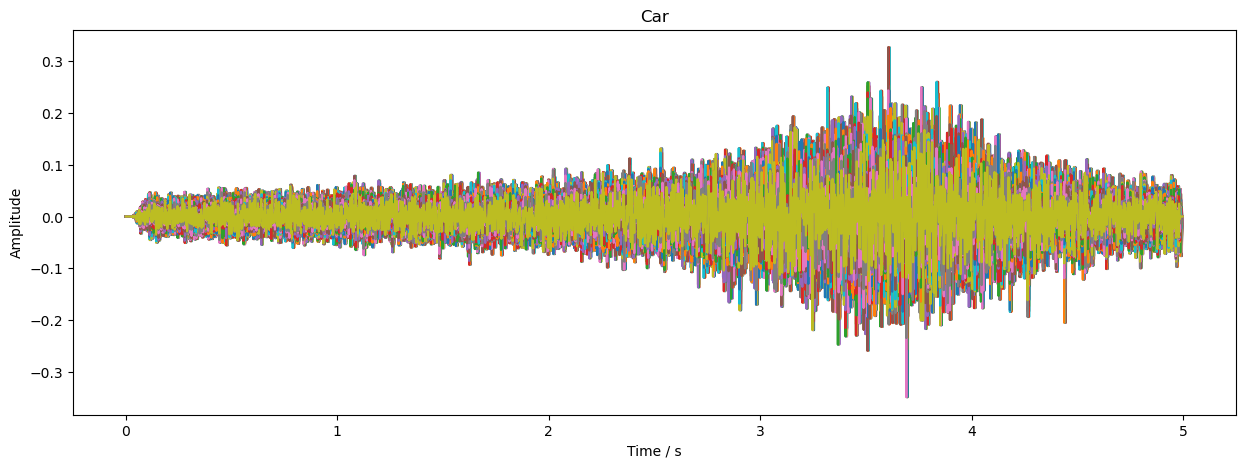

In [8]:
#visualizing car_sound-file
plt.figure(figsize = (15, 5))
plt.plot(np.linspace(0, 5, num=len(car_sound), endpoint=False), car_sound[0:])
plt.title('Car')
plt.xlabel('Time / s')
plt.ylabel('Amplitude')

Text(0, 0.5, 'Amplitude')

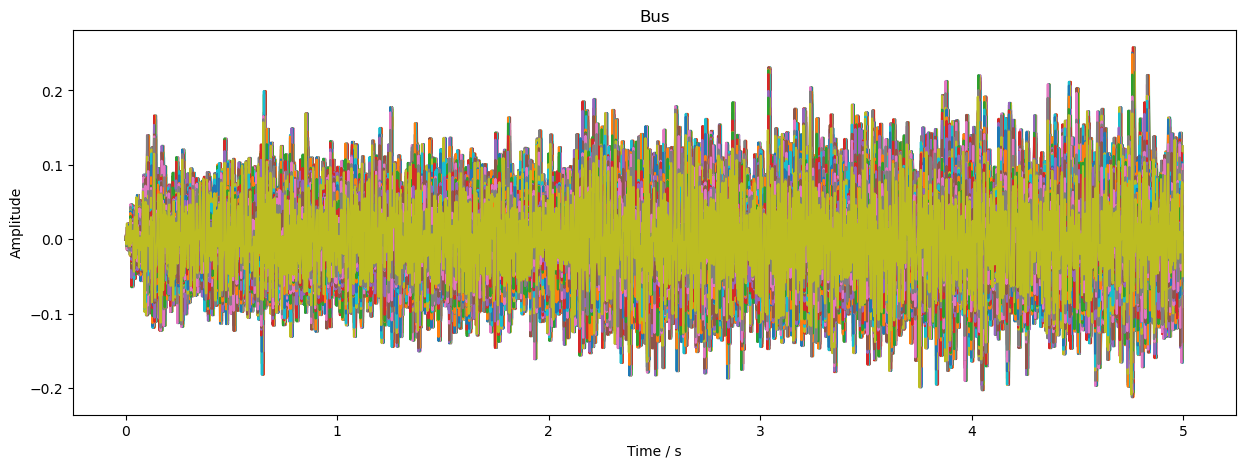

In [9]:
#visualizing bus_sound-file
plt.figure(figsize = (15, 5))
plt.plot(np.linspace(0, 5, num=len(bus_sound), endpoint=False), bus_sound[0:])
plt.title('Bus')
plt.xlabel('Time / s')
plt.ylabel('Amplitude')

In [10]:
#Concatenating the separate the vehicle classes and labels
all_audio = np.concatenate([car_sound,bus_sound])
#zeros and ones - label separation
labels_car = np.zeros(len(car_sound))
labels_bus = np.ones(len(bus_sound))
labels = np.concatenate([labels_car,labels_bus])

print(all_audio.shape)
print(labels.shape)

(4724, 259)
(4724,)


In [11]:
# creating train_test_split
x_train, x_val, y_train, y_val = train_test_split(np.array(all_audio),np.array(labels), stratify=labels,test_size = 0.2,
                                                   random_state=42,shuffle=True)

In [12]:
#checking that train_test_split worked.
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(3779, 259) (945, 259) (3779,) (945,)


In [13]:
#reshaping
x_train_features  = x_train.reshape(len(x_train),-1,1)
x_val_features = x_val.reshape(len(x_val),-1,1)
print("reshaped array",x_train_features.shape)
print("reshaped array",x_val_features.shape)

reshaped array (3779, 259, 1)
reshaped array (945, 259, 1)


In [14]:
#Model for CNN
from keras.layers import Conv1D, Dropout, MaxPooling1D, GlobalMaxPool1D, Dense, Input 
from keras.models import *
from keras.callbacks import *
from keras import backend as back
def conv_net(x_train):
  back.clear_session()
  inputs = Input(shape=(x_train.shape[1],x_train.shape[2]))
  x = Conv1D(8, 13, padding='same', activation='relu')(inputs)
  x = Dropout(0.27)(x)
  x = MaxPooling1D(2)(x)
  x = Conv1D(16, 11, padding='same', activation='relu')(x)
  x = Dropout(0.27)(x)
  x = MaxPooling1D(2)(x)
  x = GlobalMaxPool1D()(x)
  x = Dense(16, activation='relu')(x)
  outputs = Dense(1,activation='sigmoid')(x) #softmax -> 0.65
  model = Model(inputs, outputs)
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
  mc = ModelCheckpoint('best_val_acc_model.hdf5', monitor='val_acc',
                                 verbose=1, save_best_only=True, mode='max')
  return model, mc



In [15]:
model, mc = conv_net(x_train_features)

In [16]:
#summary for CNN
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 259, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 259, 8)            112       
                                                                 
 dropout (Dropout)           (None, 259, 8)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 129, 8)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 129, 16)           1424      
                                                                 
 dropout_1 (Dropout)         (None, 129, 16)           0         
                                                             

In [17]:
#fit the model
history=model.fit(x_train_features, y_train ,epochs=85, callbacks=[mc], 
batch_size=64, validation_data=(x_val_features,y_val))

Epoch 1/85
59/60 [============================>.] - ETA: 0s - loss: 0.6529 - acc: 0.7770
Epoch 1: val_acc improved from -inf to 0.81058, saving model to best_val_acc_model.hdf5
60/60 [==============================] - 2s 14ms/step - loss: 0.6528 - acc: 0.7772 - val_loss: 0.6105 - val_acc: 0.8106
Epoch 2/85
58/60 [============================>.] - ETA: 0s - loss: 0.5009 - acc: 0.7931
Epoch 2: val_acc did not improve from 0.81058
60/60 [==============================] - 1s 11ms/step - loss: 0.4984 - acc: 0.7941 - val_loss: 0.4854 - val_acc: 0.8095
Epoch 3/85
60/60 [==============================] - ETA: 0s - loss: 0.4281 - acc: 0.8068
Epoch 3: val_acc did not improve from 0.81058
60/60 [==============================] - 1s 13ms/step - loss: 0.4281 - acc: 0.8068 - val_loss: 0.4480 - val_acc: 0.8011
Epoch 4/85
55/60 [==========================>...] - ETA: 0s - loss: 0.3820 - acc: 0.8310
Epoch 4: val_acc did not improve from 0.81058
60/60 [==============================] - 1s 11ms/step - lo

57/60 [===========================>..] - ETA: 0s - loss: 0.2183 - acc: 0.9076
Epoch 31: val_acc did not improve from 0.91111
60/60 [==============================] - 1s 11ms/step - loss: 0.2199 - acc: 0.9066 - val_loss: 0.2591 - val_acc: 0.9026
Epoch 32/85
55/60 [==========================>...] - ETA: 0s - loss: 0.2127 - acc: 0.9108
Epoch 32: val_acc improved from 0.91111 to 0.91217, saving model to best_val_acc_model.hdf5
60/60 [==============================] - 1s 11ms/step - loss: 0.2141 - acc: 0.9098 - val_loss: 0.2469 - val_acc: 0.9122
Epoch 33/85
54/60 [==========================>...] - ETA: 0s - loss: 0.2173 - acc: 0.9086
Epoch 33: val_acc improved from 0.91217 to 0.91534, saving model to best_val_acc_model.hdf5
60/60 [==============================] - 1s 11ms/step - loss: 0.2147 - acc: 0.9111 - val_loss: 0.2447 - val_acc: 0.9153
Epoch 34/85
55/60 [==========================>...] - ETA: 0s - loss: 0.2094 - acc: 0.9139
Epoch 34: val_acc did not improve from 0.91534
60/60 [=======

60/60 [==============================] - 1s 10ms/step - loss: 0.1766 - acc: 0.9272 - val_loss: 0.2063 - val_acc: 0.9323
Epoch 62/85
55/60 [==========================>...] - ETA: 0s - loss: 0.1673 - acc: 0.9312
Epoch 62: val_acc did not improve from 0.93333
60/60 [==============================] - 1s 10ms/step - loss: 0.1703 - acc: 0.9291 - val_loss: 0.2000 - val_acc: 0.9323
Epoch 63/85
54/60 [==========================>...] - ETA: 0s - loss: 0.1693 - acc: 0.9314
Epoch 63: val_acc did not improve from 0.93333
60/60 [==============================] - 1s 10ms/step - loss: 0.1710 - acc: 0.9304 - val_loss: 0.2013 - val_acc: 0.9302
Epoch 64/85
55/60 [==========================>...] - ETA: 0s - loss: 0.1783 - acc: 0.9276
Epoch 64: val_acc improved from 0.93333 to 0.93651, saving model to best_val_acc_model.hdf5
60/60 [==============================] - 1s 10ms/step - loss: 0.1766 - acc: 0.9278 - val_loss: 0.2022 - val_acc: 0.9365
Epoch 65/85
54/60 [==========================>...] - ETA: 0s - l

In [18]:
#load the newly acquired model weights
model.load_weights('best_val_acc_model.hdf5')

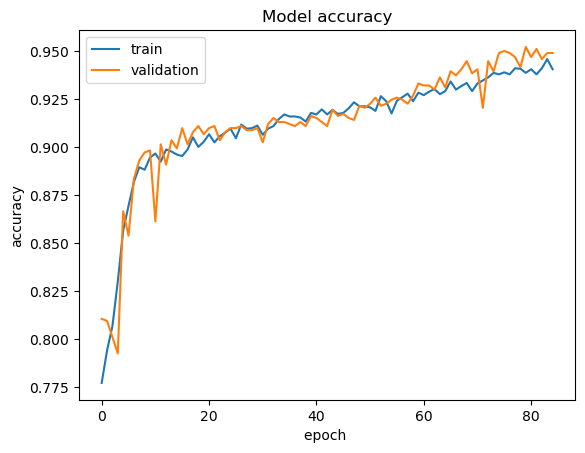

In [19]:
#plot model accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('epoch ')
plt.ylabel('accuracy')
plt.legend(['train','validation'],loc = 'upper left')
plt.show()

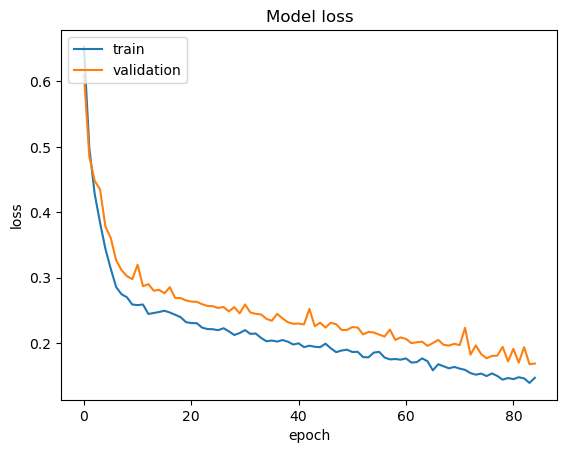

In [20]:
#plot model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','validation'],loc = 'upper left')
plt.show()

In [21]:
# evaluate model
_, acc = model.evaluate(x_val_features,y_val)
print("Validation Accuracy:",acc)
print("Validation Loss:", _)

30/30 [==============================] - 0s 3ms/step - loss: 0.1721 - acc: 0.9524
Validation Accuracy: 0.9523809552192688
Validation Loss: 0.17210884392261505


In [22]:
# test if prediction works
i=2                       #change this index for to test other sounds
play_audio = x_val[i].reshape(-1,1)
ipd.Audio(play_audio, rate=sr)

1/1 [==============================] - 0s 115ms/step
Prediction: bus sound
Probability: 0.99046725
if probability is between 0 and 0.4999... -> car (lower is better)
if probability is between 0.5 and 1.0 -> bus (higher is better)


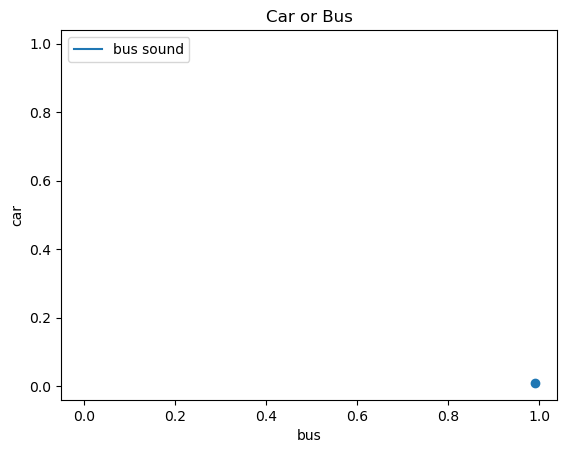

In [23]:
feat = x_val_features[i]
probability = model.predict(feat.reshape(1,-1,1))
if (probability[0][0] < 0.5 ):
 prediction ='car sound'
else:
 prediction ='bus sound'
print("Prediction:", prediction)
print("Probability:", probability[0][0])
print("if probability is between 0 and 0.4999... -> car (lower is better)")
print("if probability is between 0.5 and 1.0 -> bus (higher is better)")

plt.plot(probability[0][0])
p1= [probability[0][0]]
p2 = [1-(probability[0][0])]
plt.title('Car or Bus')
plt.xlabel('bus')
plt.ylabel('car')
plt.legend([prediction],loc = 'upper left')
plt.scatter(p1, p2)
plt.show()

In [24]:
# creating log-spectrogram
def create_log_spectrogram(all_audio, sr, ep_s=0.00000000001):
   nperseg  = 25
   noverlap = 20
   f, t, spec = signal.spectrogram(all_audio,fs=sr,
                           nperseg=nperseg,noverlap=noverlap,detrend=False)
   return f, t, np.log(spec.T.astype(np.float32) + ep_s)

In [25]:
#feature extraction
def feature_extraction(x_train):
 feature_data=[]
 for feat in x_train:
   _,_, spectrogram = create_log_spectrogram(feat, sr)  #needs two _,_

   standard_deviation = np.std(spectrogram, axis=0)
   mean_average = np.mean(spectrogram, axis=0)
   spectrogram = (spectrogram - mean_average) / standard_deviation
   feature_data.append(spectrogram)
 return np.array(feature_data)

In [26]:
x_train_features  = feature_extraction(x_train)
x_val_features = feature_extraction(x_val)


In [27]:
model, mc = conv_net(x_train_features)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 47, 13)]          0         
                                                                 
 conv1d (Conv1D)             (None, 47, 8)             1360      
                                                                 
 dropout (Dropout)           (None, 47, 8)             0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 23, 8)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 23, 16)            1424      
                                                                 
 dropout_1 (Dropout)         (None, 23, 16)            0         
                                                             

In [34]:
#fit model
history=model.fit(x_train_features, y_train, epochs=85, callbacks=[mc], batch_size=64, validation_data=(x_val_features,y_val))

Epoch 1/85
57/60 [===========================>..] - ETA: 0s - loss: 0.1432 - acc: 0.9441
Epoch 1: val_acc did not improve from 0.95450
60/60 [==============================] - 0s 8ms/step - loss: 0.1425 - acc: 0.9450 - val_loss: 0.1790 - val_acc: 0.9354
Epoch 2/85
54/60 [==========================>...] - ETA: 0s - loss: 0.1348 - acc: 0.9462
Epoch 2: val_acc did not improve from 0.95450
60/60 [==============================] - 0s 7ms/step - loss: 0.1370 - acc: 0.9463 - val_loss: 0.1641 - val_acc: 0.9471
Epoch 3/85
59/60 [============================>.] - ETA: 0s - loss: 0.1421 - acc: 0.9383
Epoch 3: val_acc did not improve from 0.95450
60/60 [==============================] - 0s 7ms/step - loss: 0.1423 - acc: 0.9381 - val_loss: 0.1541 - val_acc: 0.9492
Epoch 4/85
52/60 [=========================>....] - ETA: 0s - loss: 0.1517 - acc: 0.9384
Epoch 4: val_acc did not improve from 0.95450
60/60 [==============================] - 0s 7ms/step - loss: 0.1472 - acc: 0.9410 - val_loss: 0.1601 - 

59/60 [============================>.] - ETA: 0s - loss: 0.1018 - acc: 0.9576
Epoch 33: val_acc did not improve from 0.95450
60/60 [==============================] - 0s 6ms/step - loss: 0.1017 - acc: 0.9577 - val_loss: 0.1479 - val_acc: 0.9481
Epoch 34/85
52/60 [=========================>....] - ETA: 0s - loss: 0.1052 - acc: 0.9582
Epoch 34: val_acc did not improve from 0.95450
60/60 [==============================] - 0s 7ms/step - loss: 0.1037 - acc: 0.9600 - val_loss: 0.1966 - val_acc: 0.9217
Epoch 35/85
60/60 [==============================] - ETA: 0s - loss: 0.1006 - acc: 0.9587
Epoch 35: val_acc did not improve from 0.95450
60/60 [==============================] - 0s 7ms/step - loss: 0.1006 - acc: 0.9587 - val_loss: 0.1478 - val_acc: 0.9471
Epoch 36/85
57/60 [===========================>..] - ETA: 0s - loss: 0.0991 - acc: 0.9638
Epoch 36: val_acc did not improve from 0.95450
60/60 [==============================] - 0s 7ms/step - loss: 0.0997 - acc: 0.9637 - val_loss: 0.1518 - val_

KeyboardInterrupt: 

In [29]:
#load new weights and evaluate model
model.load_weights('best_val_acc_model.hdf5')

_,acc = model.evaluate(x_val_features,y_val)
print("Accuracy:",acc)
print("Validation Loss:", _)

30/30 [==============================] - 0s 2ms/step - loss: 0.1528 - acc: 0.9545
Accuracy: 0.9544973373413086
Validation Loss: 0.152765154838562


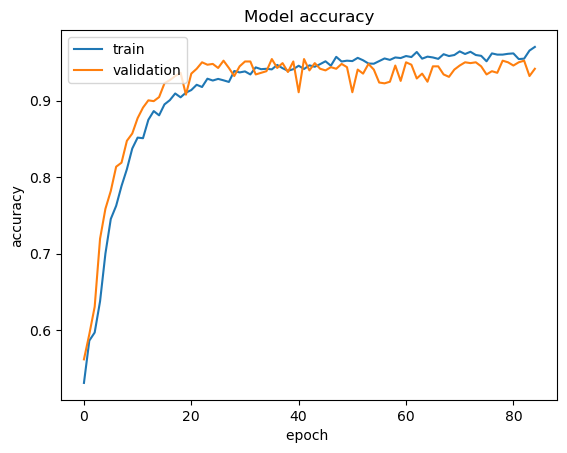

In [30]:
#plot model accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('epoch ')
plt.ylabel('accuracy')
plt.legend(['train','validation'],loc = 'upper left')
plt.show()

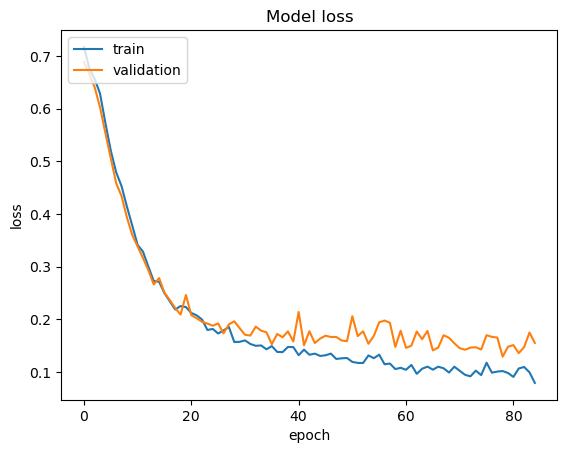

In [31]:
#plot model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','validation'],loc = 'upper left')
plt.show()

In [32]:
#test model
i=2                #change this index for to test other sounds
play_audio = x_val[i]
ipd.Audio(play_audio, rate=sr)

1/1 [==============================] - 0s 79ms/step
Prediction: bus sound
Probability: 0.9686131
if probability is between 0 and 0.4999... -> car (lower is better)
if probability is between 0.5 and 1.0 -> bus (higher is better)


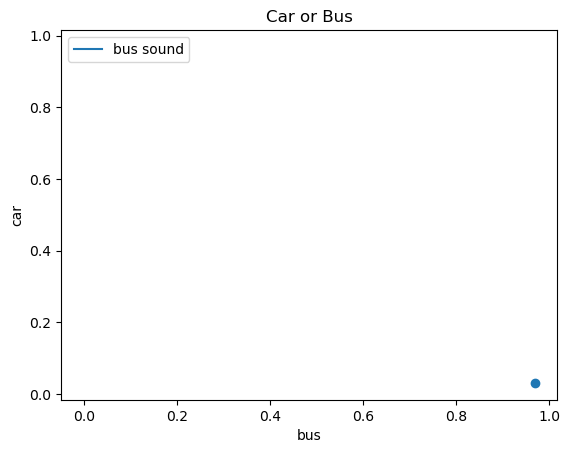

In [33]:
feat = x_val_features[i]
probability = model.predict(feat.reshape(1,-1,feat.shape[1]))
if (probability[0][0] < 0.5 ):  
    prediction ='car sound'
else:
    prediction ='bus sound'
print("Prediction:", prediction)
print("Probability:", probability[0][0])
print("if probability is between 0 and 0.4999... -> car (lower is better)")
print("if probability is between 0.5 and 1.0 -> bus (higher is better)")

plt.plot(probability[0][0])
p1= [probability[0][0]]
p2 = [1-(probability[0][0])]
plt.title('Car or Bus')
plt.xlabel('bus')
plt.ylabel('car')
plt.legend([prediction],loc = 'upper left')
plt.scatter(p1, p2)
plt.show()